In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-payment-default-prediction/sample_submission_gm6gE0l.csv
/kaggle/input/credit-card-payment-default-prediction/test_O6kKpvt.csv
/kaggle/input/credit-card-payment-default-prediction/train_20D8GL3.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 1: Load Dataset
# In Kaggle, the dataset is located under /kaggle/input/
train_file_path = '/kaggle/input/credit-card-payment-default-prediction/train_20D8GL3.csv'
df = pd.read_csv(train_file_path)
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,25150,360000,2,2,2,25,-1,-1,-1,-1,...,3435,8870,2020,12590,3479,3446,8870,2020,27043,0
1,13470,240000,2,1,2,46,2,2,-2,-1,...,2240,1681,2267,0,0,2240,0,2267,3074,0
2,3092,320000,2,2,1,41,0,0,0,0,...,35409,35036,35939,5000,2000,2000,3000,3000,1500,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,1
4,10567,80000,1,3,1,52,-1,0,0,0,...,20561,21261,21457,1500,1500,1500,1028,876,1449,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          21000 non-null  int64
 1   LIMIT_BAL                   21000 non-null  int64
 2   SEX                         21000 non-null  int64
 3   EDUCATION                   21000 non-null  int64
 4   MARRIAGE                    21000 non-null  int64
 5   AGE                         21000 non-null  int64
 6   PAY_0                       21000 non-null  int64
 7   PAY_2                       21000 non-null  int64
 8   PAY_3                       21000 non-null  int64
 9   PAY_4                       21000 non-null  int64
 10  PAY_5                       21000 non-null  int64
 11  PAY_6                       21000 non-null  int64
 12  BILL_AMT1                   21000 non-null  int64
 13  BILL_AMT2                   21000 non-null  int64
 14  BILL_A

In [5]:
#renaming for better convinience
df['IsDefaulter'] =df ['default_payment_next_month']
df.drop('default_payment_next_month',axis = 1)
# df.rename({'default.payment.next.month' : 'IsDefaulter'}, inplace=True)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IsDefaulter
0,25150,360000,2,2,2,25,-1,-1,-1,-1,...,3435,8870,2020,12590,3479,3446,8870,2020,27043,0
1,13470,240000,2,1,2,46,2,2,-2,-1,...,2240,1681,2267,0,0,2240,0,2267,3074,0
2,3092,320000,2,2,1,41,0,0,0,0,...,35409,35036,35939,5000,2000,2000,3000,3000,1500,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,1
4,10567,80000,1,3,1,52,-1,0,0,0,...,20561,21261,21457,1500,1500,1500,1028,876,1449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,6283,50000,2,2,2,31,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
20996,25589,80000,2,2,1,37,0,0,0,0,...,45458,48679,49895,5000,3000,2000,4000,2000,2000,0
20997,4378,100000,1,1,1,52,1,2,2,2,...,23440,28843,31353,0,3600,0,6000,3000,0,1
20998,8604,90000,2,2,1,47,0,0,0,0,...,28747,29177,29452,2000,2000,2000,2000,2000,2000,0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='IsDefaulter', ylabel='count'>

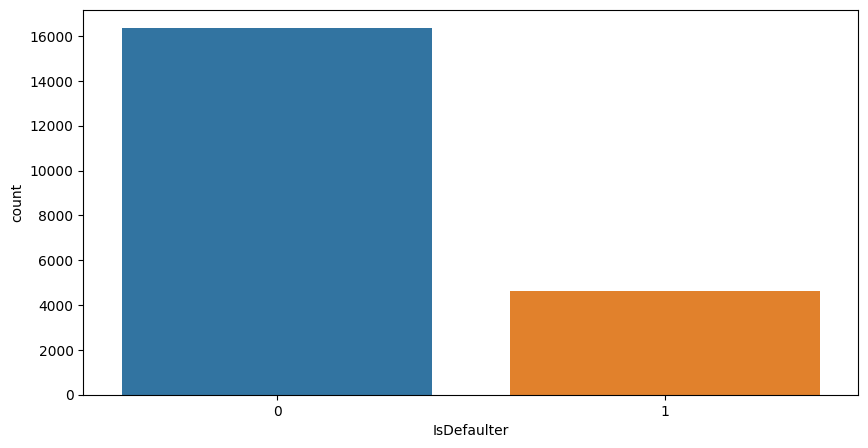

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'IsDefaulter', data = df)

In [8]:
df['IsDefaulter'].value_counts()

IsDefaulter
0    16355
1     4645
Name: count, dtype: int64

In [9]:
fil = (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 0)
df.loc[fil, 'EDUCATION'] = 4
df['EDUCATION'].value_counts()

EDUCATION
2    9789
1    7415
3    3467
4     329
Name: count, dtype: int64

In [10]:
fil = df['MARRIAGE'] == 0
df.loc[fil, 'MARRIAGE'] = 3
df['MARRIAGE'].value_counts()

MARRIAGE
2    11184
1     9561
3      255
Name: count, dtype: int64

In [11]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

In [12]:
df_cat = df[categorical_features]
df_cat['Defaulter'] = df['IsDefaulter']

In [13]:
df_cat.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

<Figure size 1000x500 with 0 Axes>

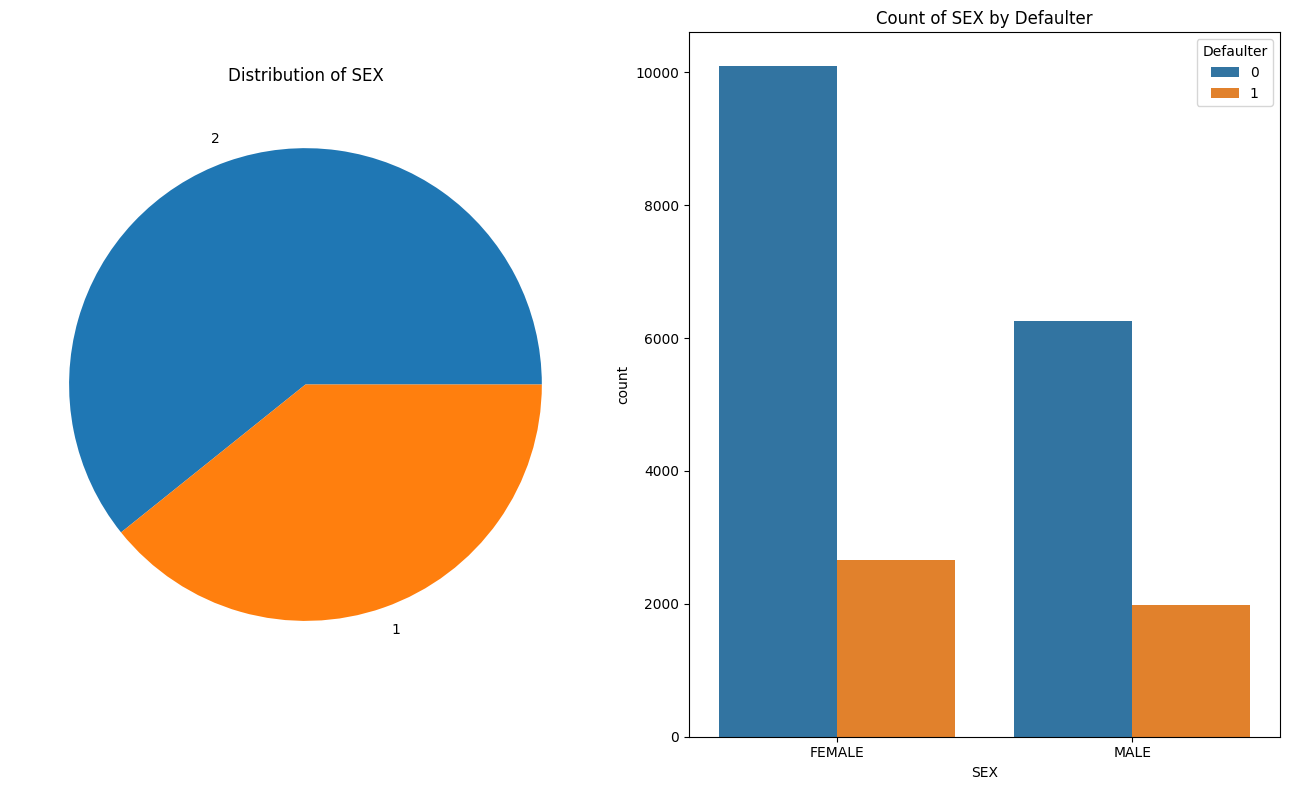

<Figure size 1000x500 with 0 Axes>

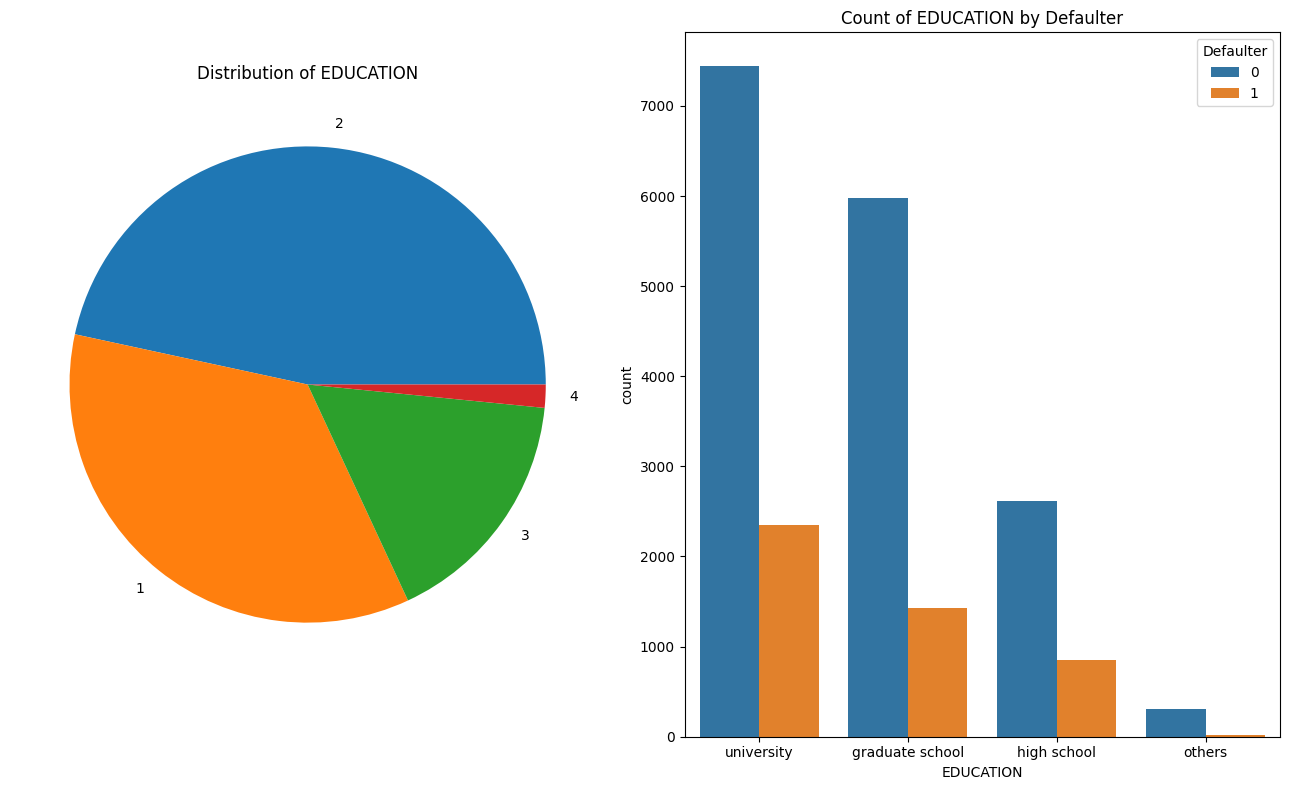

<Figure size 1000x500 with 0 Axes>

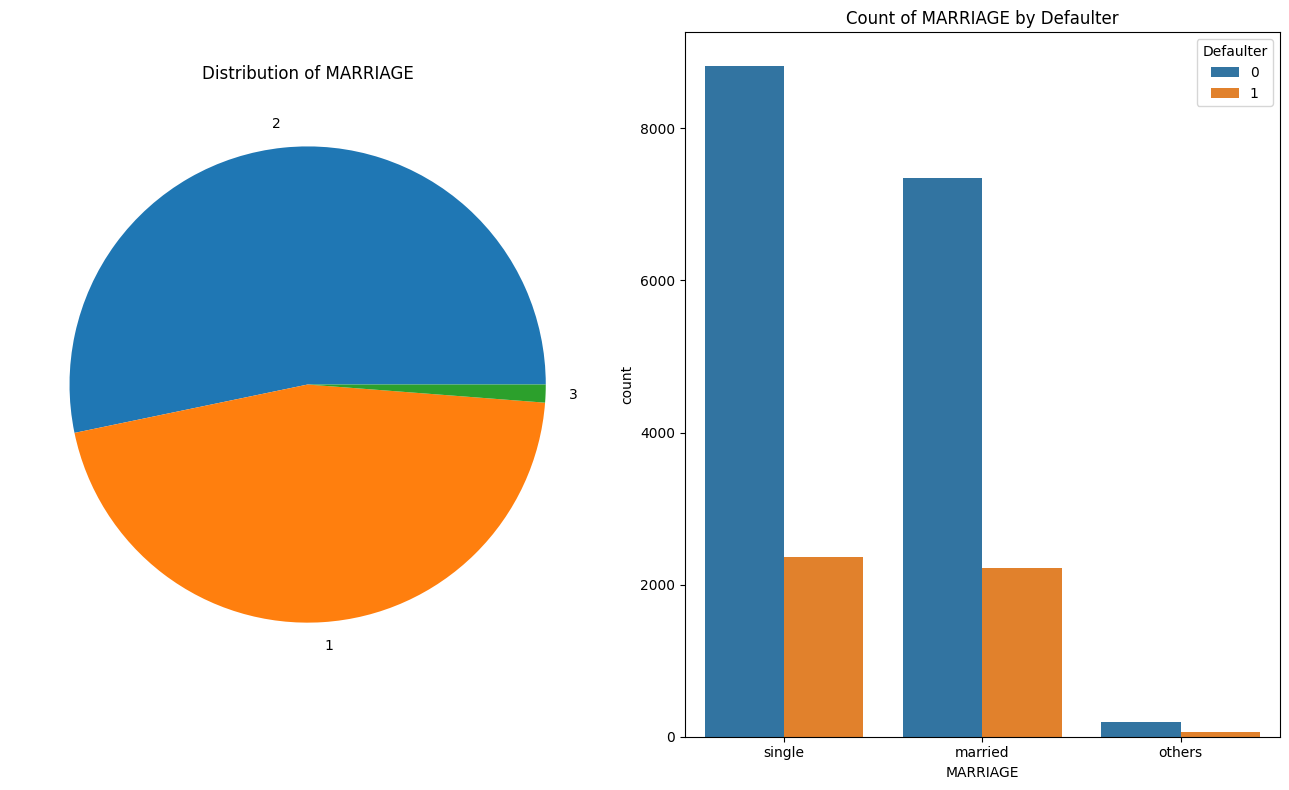

In [14]:
 for col in categorical_features:
  plt.figure(figsize=(10,5))
  fig, axes = plt.subplots(ncols=2,figsize=(13,8))
  df[col].value_counts().plot(kind="pie",ax = axes[0],subplots=True)
  axes[0].set_title(f'Distribution of {col}')
  axes[0].set_ylabel('') 
  sns.countplot(x = col, hue = 'Defaulter', data = df_cat)
  axes[1].set_title(f'Count of {col} by Defaulter')
  plt.tight_layout()
plt.show()

In [15]:
df['LIMIT_BAL'].describe()

count     21000.000000
mean     167214.746667
std      128965.188482
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      240000.000000
max      800000.000000
Name: LIMIT_BAL, dtype: float64

<Axes: xlabel='IsDefaulter', ylabel='LIMIT_BAL'>

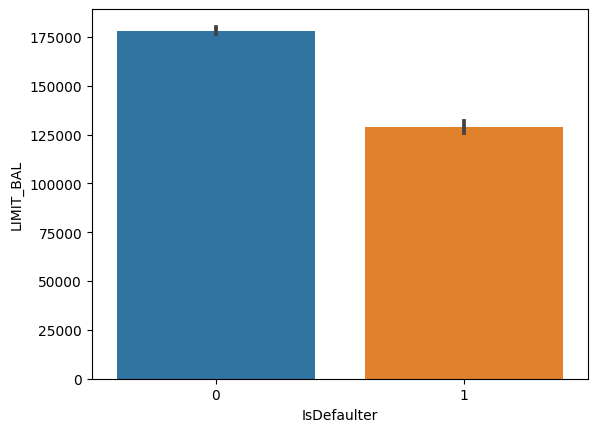

In [16]:
sns.barplot(x='IsDefaulter', y='LIMIT_BAL', data=df)

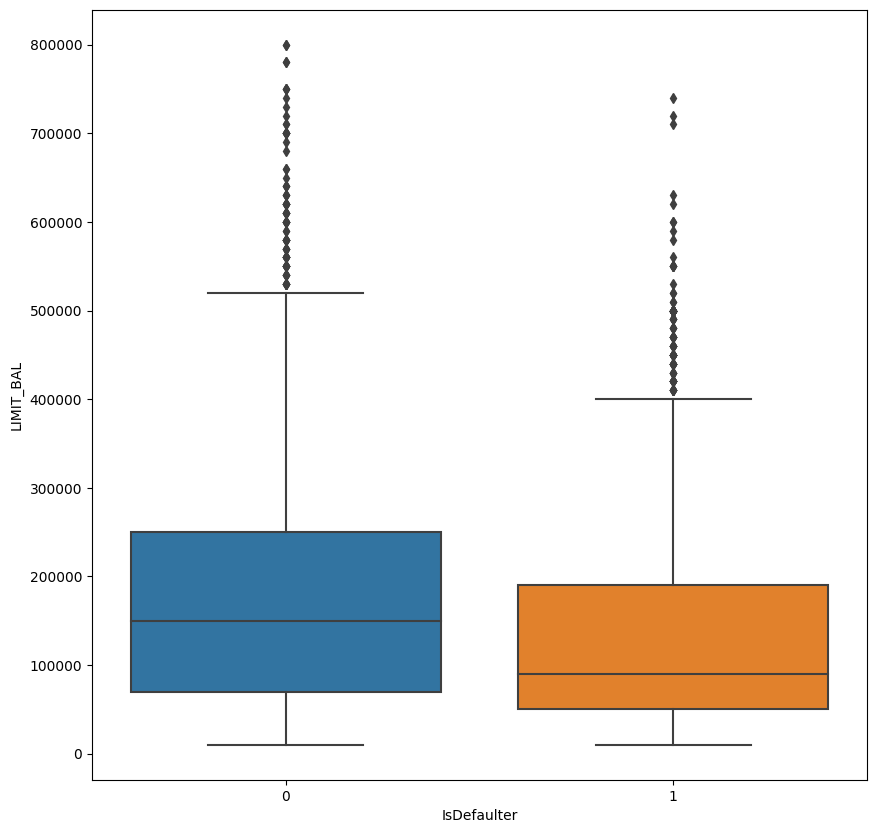

In [17]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="IsDefaulter", y="LIMIT_BAL", data=df)

In [18]:
df.rename(columns={'PAY_0':'PAY_SEPT','PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'},inplace=True)
df.rename(columns={'BILL_AMT1':'BILL_AMT_SEPT','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}, inplace = True)
df.rename(columns={'PAY_AMT1':'PAY_AMT_SEPT','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'},inplace=True)

In [19]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default_payment_next_month,IsDefaulter
0,25150,360000,2,2,2,25,-1,-1,-1,-1,...,8870,2020,12590,3479,3446,8870,2020,27043,0,0
1,13470,240000,2,1,2,46,2,2,-2,-1,...,1681,2267,0,0,2240,0,2267,3074,0,0
2,3092,320000,2,2,1,41,0,0,0,0,...,35036,35939,5000,2000,2000,3000,3000,1500,0,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,1,1
4,10567,80000,1,3,1,52,-1,0,0,0,...,21261,21457,1500,1500,1500,1028,876,1449,0,0


In [20]:
df['AGE'].value_counts()

AGE
29    1088
27    1052
28     993
30     972
26     879
25     847
32     832
31     825
34     821
33     815
36     786
35     784
24     779
37     738
38     661
39     660
23     646
40     602
41     596
42     550
44     487
43     470
45     429
46     412
22     404
47     331
48     330
49     315
50     268
51     243
53     223
52     207
54     175
55     136
56     124
58      88
57      85
59      63
60      51
21      45
61      40
63      27
62      26
66      18
64      17
65      16
67      11
69      11
70       8
68       3
75       3
71       3
72       2
73       2
74       1
Name: count, dtype: int64

In [21]:
df['AGE']=df['AGE'].astype('int')

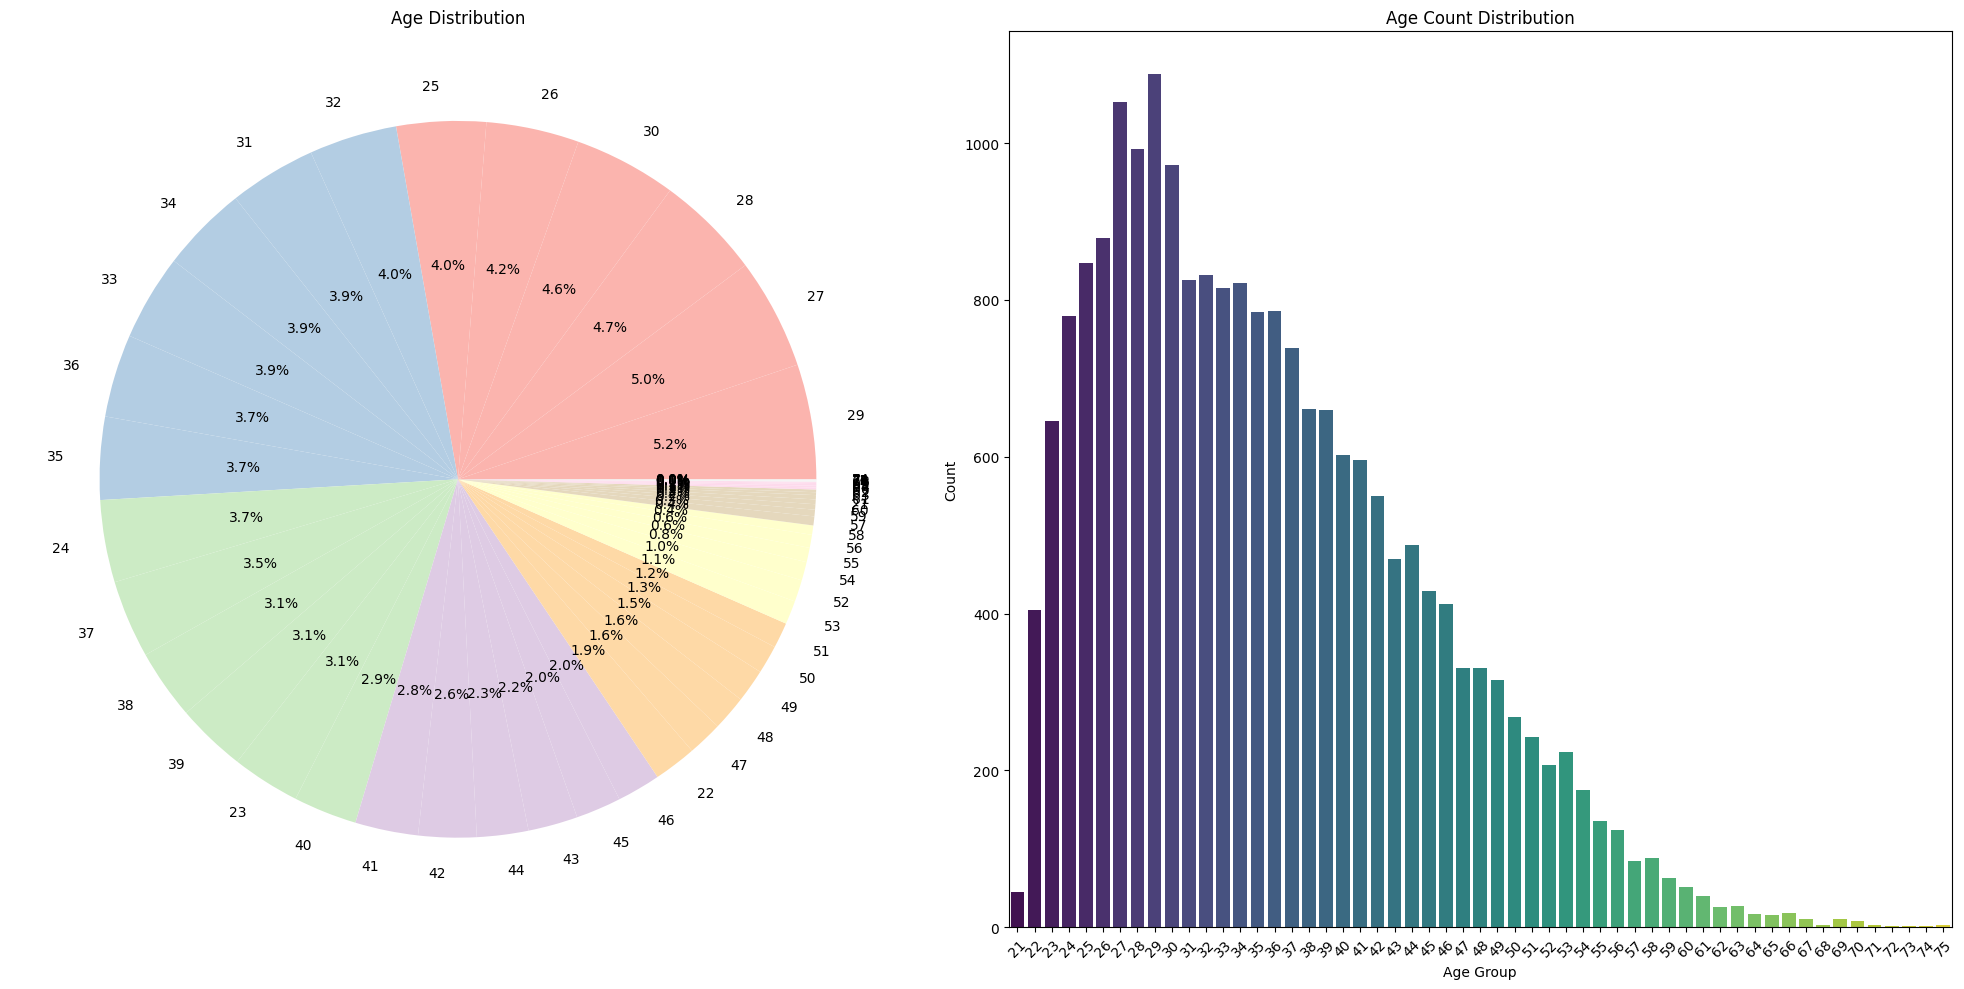

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the DataFrame with counts
Day_df = df['AGE'].value_counts().reset_index()
Day_df.columns = ['AGE_Group', 'Count']  # Rename columns for clarity

# Step 2: Plotting
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Pie chart
df['AGE'].value_counts().plot(kind="pie", ax=axes[0], autopct='%1.1f%%', colormap='Pastel1')
axes[0].set_ylabel('')
axes[0].set_title('Age Distribution')

# Bar plot with custom colors
sns.barplot(x='AGE_Group', y='Count', data=Day_df, ax=axes[1], palette='viridis')
axes[1].set_title('Age Count Distribution')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [23]:
df.groupby('IsDefaulter')['AGE'].mean()

IsDefaulter
0    35.428921
1    35.576749
Name: AGE, dtype: float64

In [24]:
df = df.astype('int')

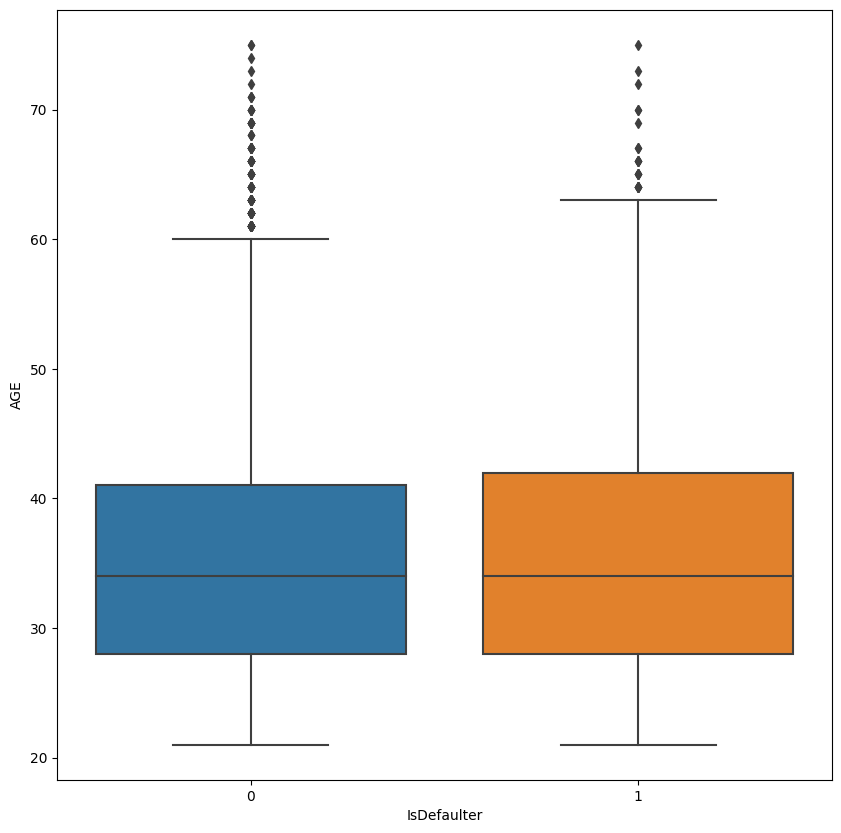

In [25]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x="IsDefaulter", y="AGE", data=df)


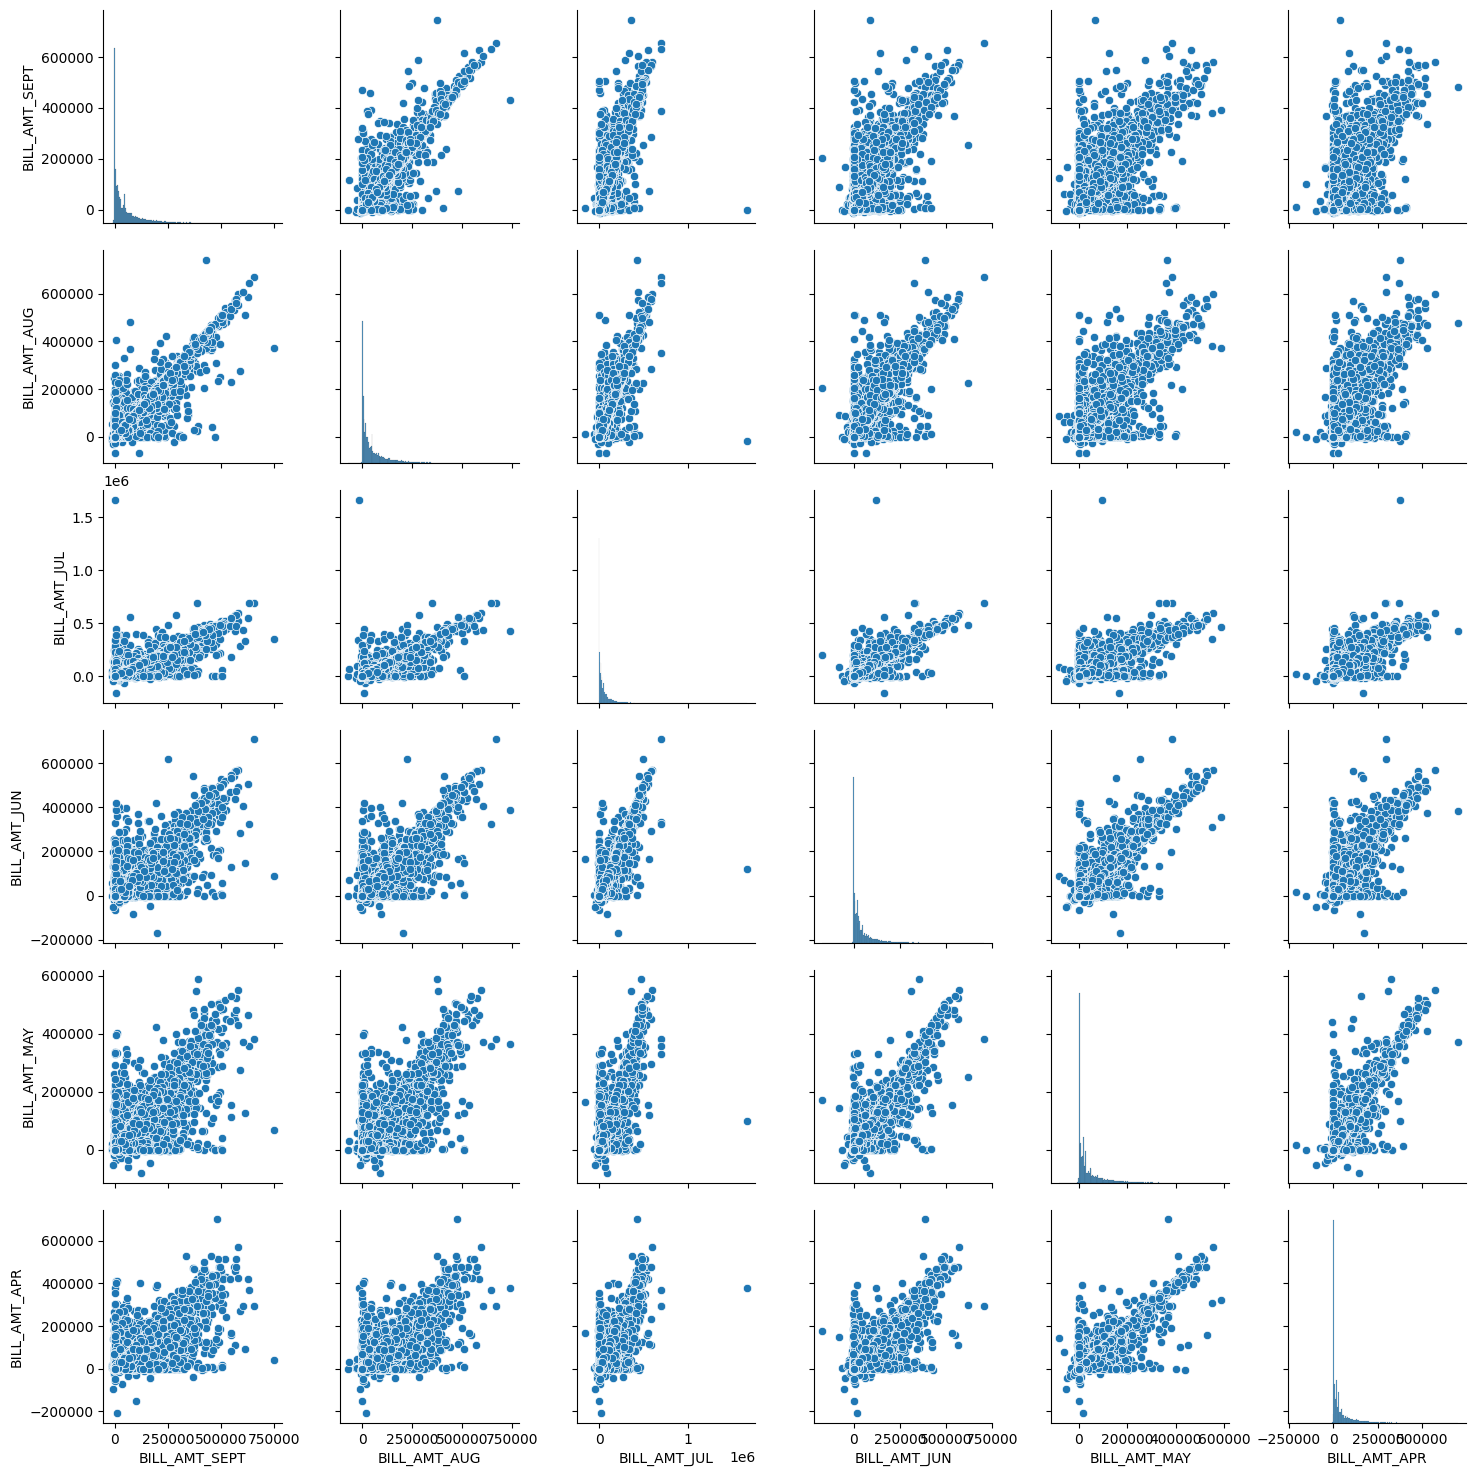

In [26]:
bill_amnt_df = df[['BILL_AMT_SEPT',	'BILL_AMT_AUG',	'BILL_AMT_JUL',	'BILL_AMT_JUN',	'BILL_AMT_MAY',	'BILL_AMT_APR']]
sns.pairplot(data = bill_amnt_df)

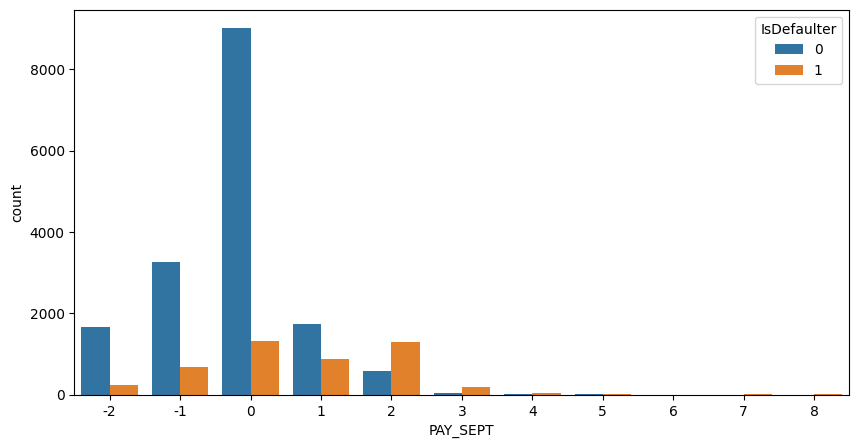

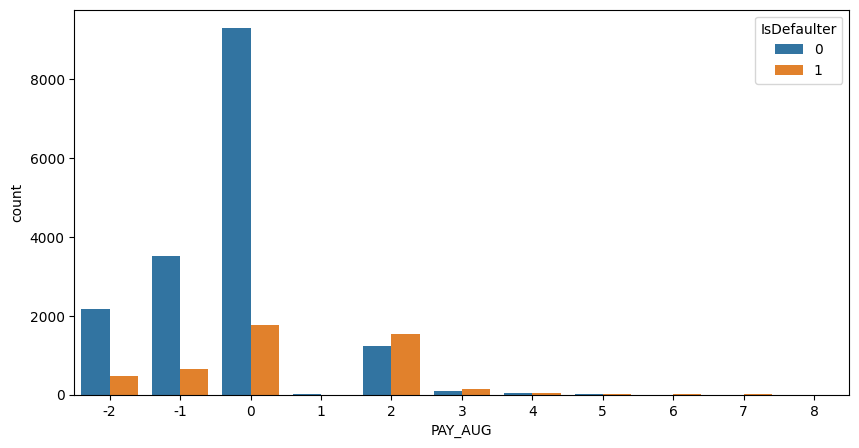

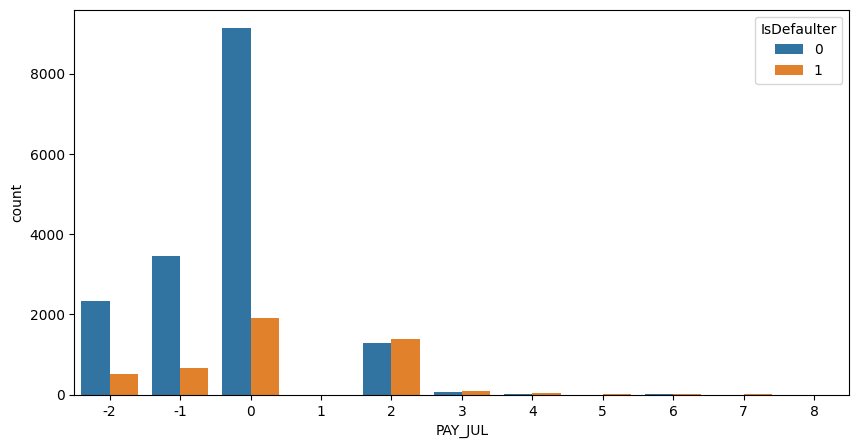

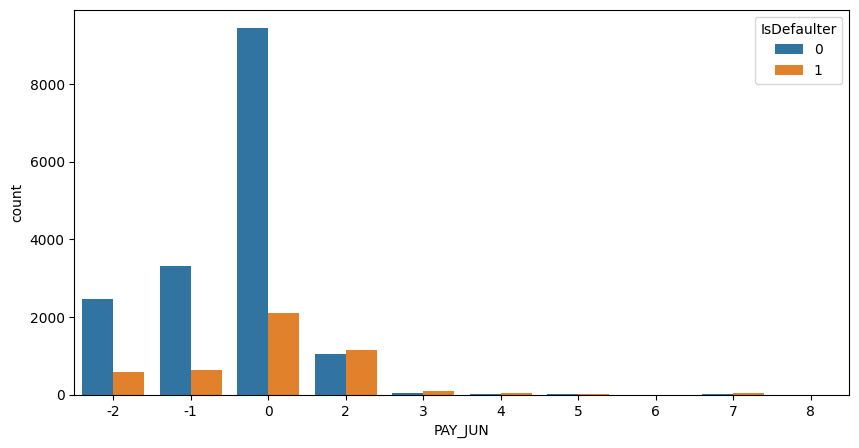

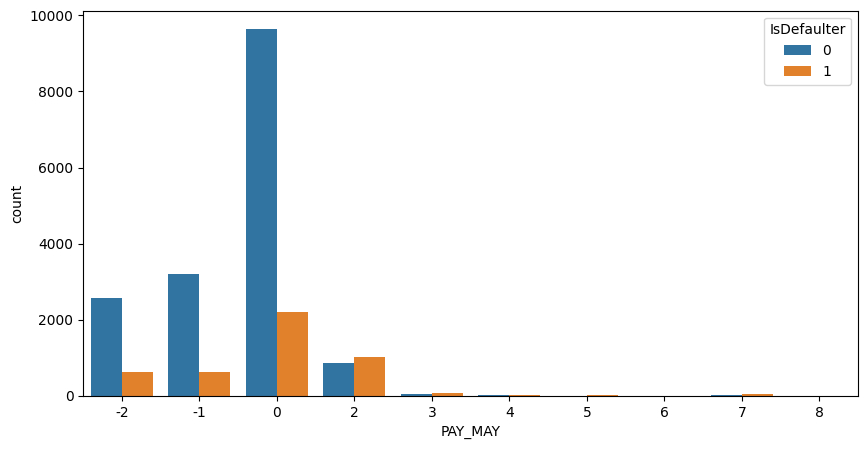

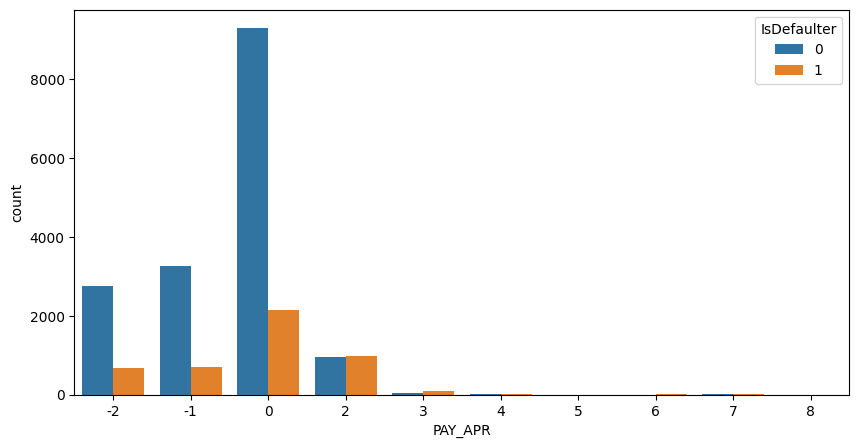

In [27]:
pay_col = ['PAY_SEPT',	'PAY_AUG',	'PAY_JUL',	'PAY_JUN',	'PAY_MAY',	'PAY_APR']
for col in pay_col:
  plt.figure(figsize=(10,5))
  sns.countplot(x = col, hue = 'IsDefaulter', data = df)

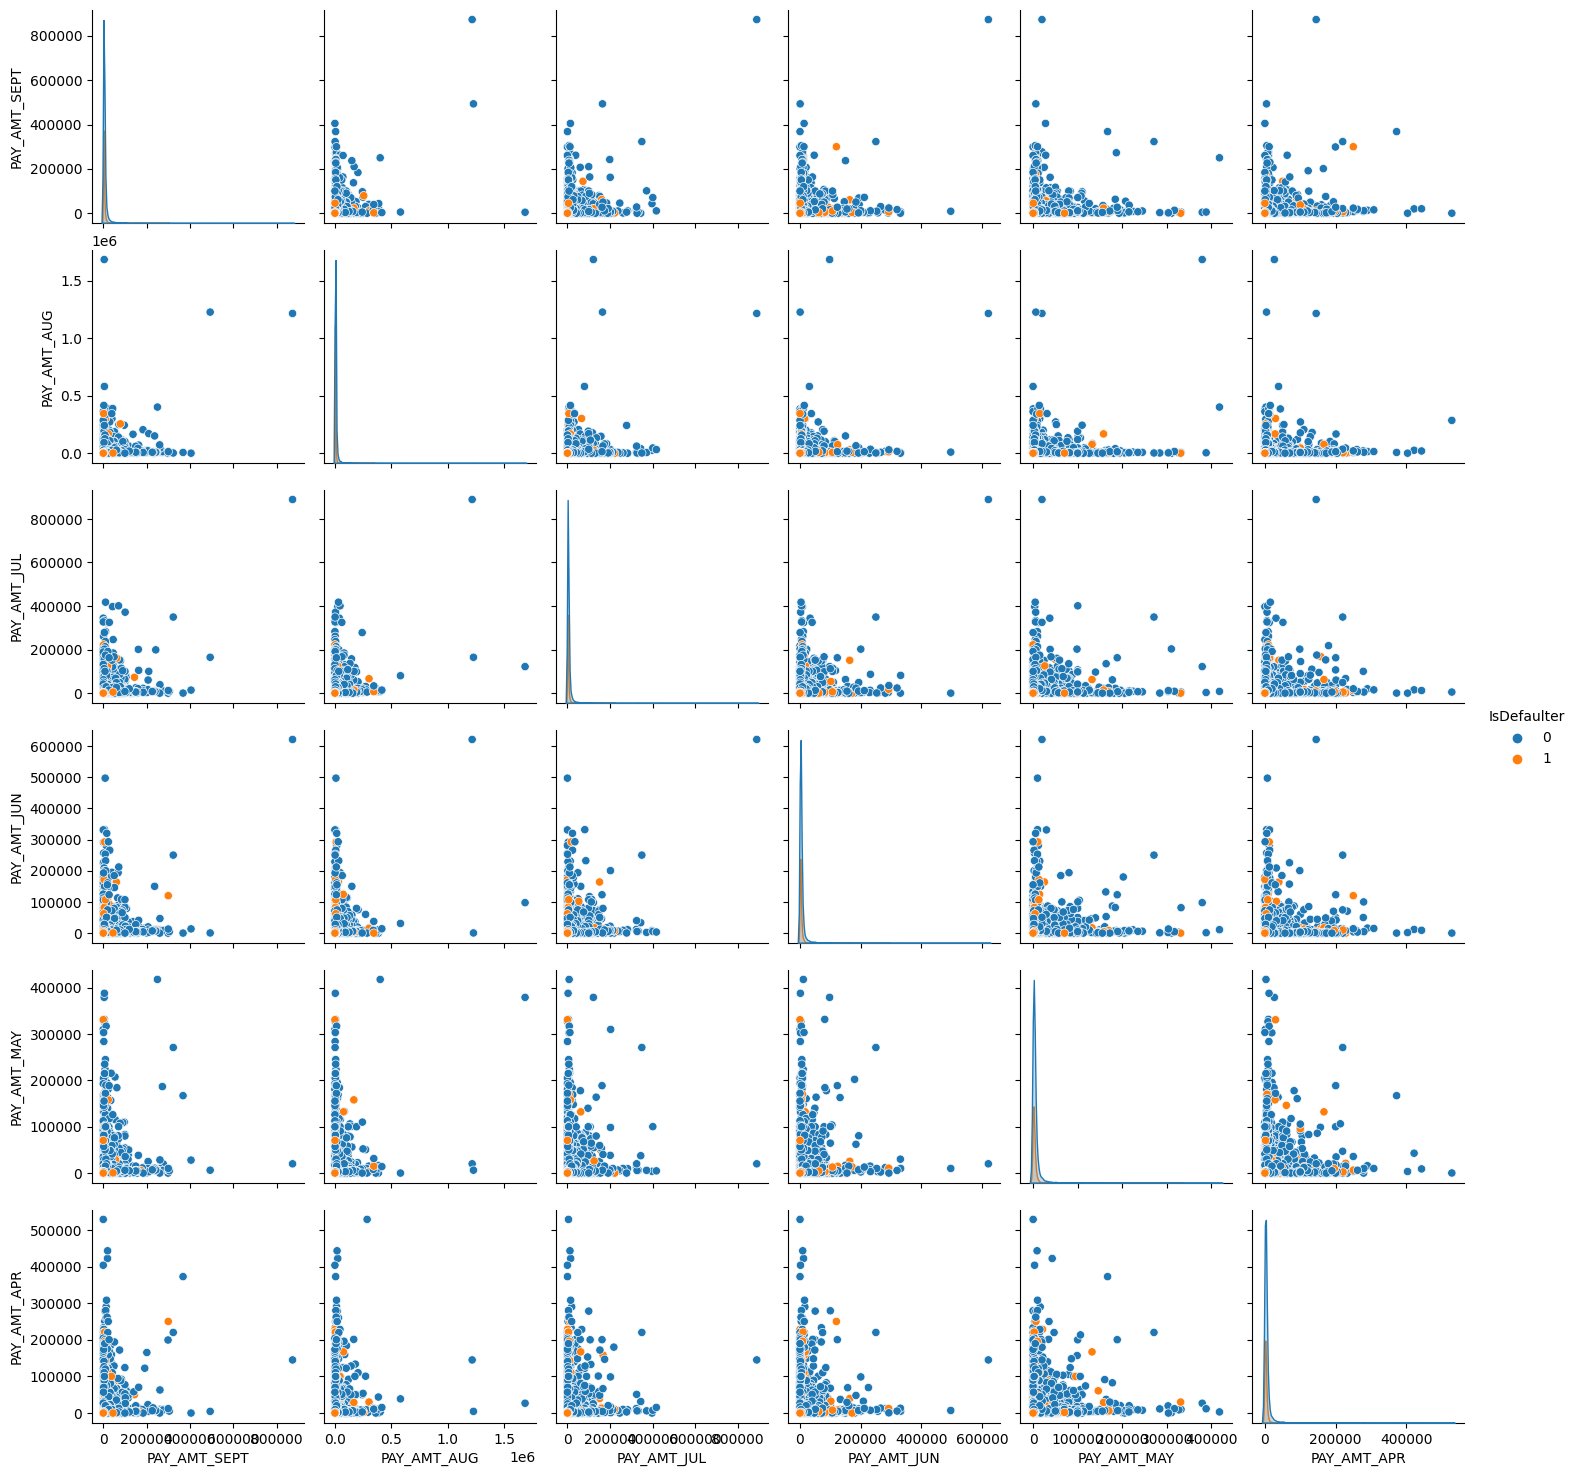

In [28]:
pay_amnt_df = df[['PAY_AMT_SEPT',	'PAY_AMT_AUG',	'PAY_AMT_JUL',	'PAY_AMT_JUN',	'PAY_AMT_MAY',	'PAY_AMT_APR', 'IsDefaulter']]
sns.pairplot(data = pay_amnt_df, hue='IsDefaulter')

In [29]:
df.shape

(21000, 26)

# BALANCING DATASET

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df.iloc[:,0:-1], df['IsDefaulter'])

print('Original dataset shape', len(df))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 21000
Resampled dataset shape 32710


In [31]:
x_smote

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default_payment_next_month
0,25150,360000,2,2,2,25,-1,-1,-1,-1,...,3435,8870,2020,12590,3479,3446,8870,2020,27043,0
1,13470,240000,2,1,2,46,2,2,-2,-1,...,2240,1681,2267,0,0,2240,0,2267,3074,0
2,3092,320000,2,2,1,41,0,0,0,0,...,35409,35036,35939,5000,2000,2000,3000,3000,1500,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,1
4,10567,80000,1,3,1,52,-1,0,0,0,...,20561,21261,21457,1500,1500,1500,1028,876,1449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32705,19840,60000,2,2,1,25,2,1,1,1,...,41123,29232,29881,635,3044,695,2007,1207,493,1
32706,17118,58140,1,2,1,31,1,2,0,0,...,20014,19762,33327,0,1433,2269,371,13954,1628,1
32707,26351,57406,1,1,1,39,1,2,0,0,...,57243,8684,8326,518,2221,2555,2628,833,474,1
32708,8730,184305,1,1,1,32,2,2,2,2,...,109937,108774,111315,2983,6278,4072,1857,6279,1937,1


In [32]:
columns = list(df.columns)
columns.pop()

'IsDefaulter'

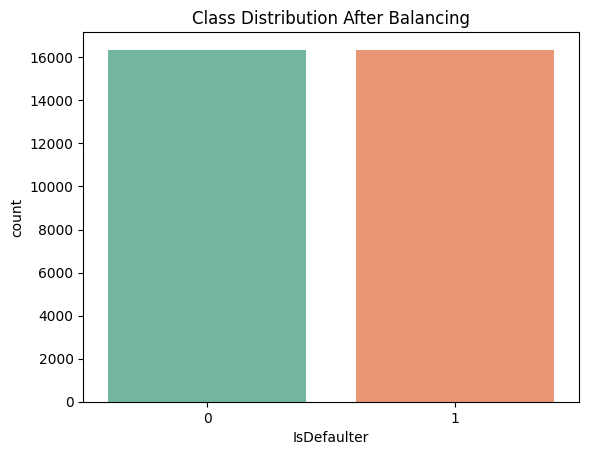

In [33]:
balance_df = pd.DataFrame(x_smote, columns=columns)
balance_df['IsDefaulter'] = y_smote

# Corrected countplot syntax
sns.countplot(x='IsDefaulter', data=balance_df, palette='Set2')
plt.title('Class Distribution After Balancing')
plt.show()


In [34]:
balance_df[balance_df['IsDefaulter']==1]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default_payment_next_month,IsDefaulter
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,1,1
5,28050,150000,2,1,2,29,-2,-2,-2,-2,...,0,14001,5067,131,987,400,14001,0,1,1
10,196,50000,2,1,2,24,1,2,2,2,...,39228,40035,1900,1400,1700,1532,1600,0,1,1
20,4982,240000,1,3,1,43,-1,-1,2,2,...,2500,0,2500,0,0,0,0,0,1,1
21,5928,320000,2,1,2,29,0,0,-2,-1,...,16177,16706,0,0,364,16177,800,650,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32705,19840,60000,2,2,1,25,2,1,1,1,...,29232,29881,635,3044,695,2007,1207,493,1,1
32706,17118,58140,1,2,1,31,1,2,0,0,...,19762,33327,0,1433,2269,371,13954,1628,1,1
32707,26351,57406,1,1,1,39,1,2,0,0,...,8684,8326,518,2221,2555,2628,833,474,1,1
32708,8730,184305,1,1,1,32,2,2,2,2,...,108774,111315,2983,6278,4072,1857,6279,1937,1,1


# FEATURE ENGINEERING

In [35]:
df_fr = balance_df.copy()

In [36]:
df_fr['Payement_Value'] = df_fr['PAY_SEPT'] + df_fr['PAY_AUG'] + df_fr['PAY_JUL'] + df_fr['PAY_JUN'] + df_fr['PAY_MAY'] + df_fr['PAY_APR']
df_fr.groupby('IsDefaulter')['Payement_Value'].mean()

IsDefaulter
0   -1.965699
1    1.705961
Name: Payement_Value, dtype: float64

<Axes: xlabel='IsDefaulter', ylabel='Payement_Value'>

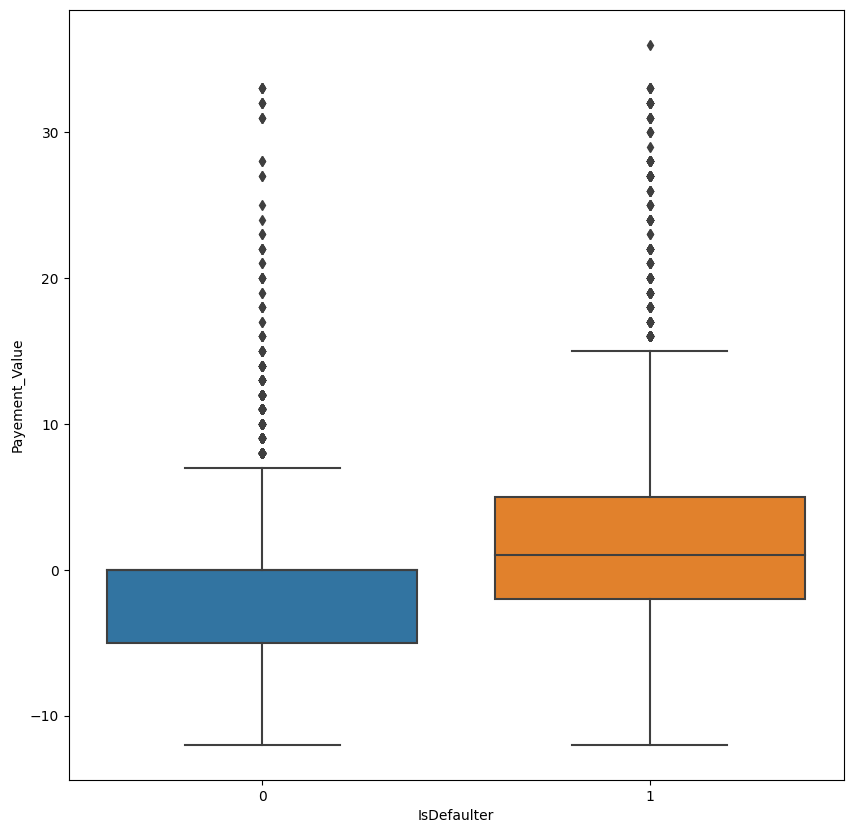

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(data = df_fr, x = 'IsDefaulter', y = 'Payement_Value' )

In [38]:
df_fr['Dues'] = (df_fr['BILL_AMT_APR']+df_fr['BILL_AMT_MAY']+df_fr['BILL_AMT_JUN']+df_fr['BILL_AMT_JUL']+df_fr['BILL_AMT_SEPT'])-(df_fr['PAY_AMT_APR']+df_fr['PAY_AMT_MAY']+df_fr['PAY_AMT_JUN']+df_fr['PAY_AMT_JUL']+df_fr['PAY_AMT_AUG']+df_fr['PAY_AMT_SEPT'])
df_fr.groupby('IsDefaulter')['Dues'].mean()

IsDefaulter
0    189843.942709
1    193200.630327
Name: Dues, dtype: float64

In [39]:
df_fr['EDUCATION'].unique()

array([2, 1, 3, 4])

In [40]:
df_fr['EDUCATION']=np.where(df_fr['EDUCATION'] == 6, 4, df_fr['EDUCATION'])
df_fr['EDUCATION']=np.where(df_fr['EDUCATION'] == 0, 4, df_fr['EDUCATION'])


In [41]:
df_fr['MARRIAGE'].unique()

array([2, 1, 3])

In [42]:

df_fr['MARRIAGE']=np.where(df_fr['MARRIAGE'] == 0, 3, df_fr['MARRIAGE'])

In [43]:
df_fr.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

In [44]:
df_fr.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default_payment_next_month,IsDefaulter,Payement_Value,Dues
0,25150,360000,FEMALE,university,single,25,-1,-1,-1,-1,...,12590,3479,3446,8870,2020,27043,0,0,-6,-18692
1,13470,240000,FEMALE,graduate school,single,46,2,2,-2,-1,...,0,0,2240,0,2267,3074,0,0,0,-937
2,3092,320000,FEMALE,university,married,41,0,0,0,0,...,5000,2000,2000,3000,3000,1500,0,0,0,178447
3,13973,50000,FEMALE,university,single,24,-1,-1,-2,-2,...,0,0,0,0,0,0,1,1,-10,2675
4,10567,80000,MALE,high school,married,52,-1,0,0,0,...,1500,1500,1500,1028,876,1449,0,0,-1,110672


# ONE HOT ENCODING

In [45]:
df_fr = pd.get_dummies(df_fr,columns=['EDUCATION','MARRIAGE'])

In [46]:
df_fr.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,...,IsDefaulter,Payement_Value,Dues,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,25150,360000,FEMALE,25,-1,-1,-1,-1,-1,-1,...,0,-6,-18692,False,False,False,True,False,False,True
1,13470,240000,FEMALE,46,2,2,-2,-1,0,-1,...,0,0,-937,True,False,False,False,False,False,True
2,3092,320000,FEMALE,41,0,0,0,0,0,0,...,0,0,178447,False,False,False,True,True,False,False
3,13973,50000,FEMALE,24,-1,-1,-2,-2,-2,-2,...,1,-10,2675,False,False,False,True,False,False,True
4,10567,80000,MALE,52,-1,0,0,0,0,0,...,0,-1,110672,False,True,False,False,True,False,False


In [47]:
print(df_fr.columns)


Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_SEPT', 'PAY_AUG', 'PAY_JUL',
       'PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_AMT_SEPT', 'BILL_AMT_AUG',
       'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY', 'BILL_AMT_APR',
       'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN',
       'PAY_AMT_MAY', 'PAY_AMT_APR', 'default_payment_next_month',
       'IsDefaulter', 'Payement_Value', 'Dues', 'EDUCATION_graduate school',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single'],
      dtype='object')


In [48]:
columns_to_drop = ['EDUCATION_others', 'MARRIAGE_others']
for col in columns_to_drop:
    if col in df_fr.columns:
        df_fr.drop(col, axis=1, inplace=True)
    else:
        print(f"Column '{col}' not found.")


In [49]:
# Check if the columns are already one-hot encoded
encoded_columns = ['PAY_SEPT_-1', 'PAY_SEPT_0', 'PAY_SEPT_1', 'PAY_SEPT_2', 
                   'PAY_AUG_-1', 'PAY_AUG_0', 'PAY_AUG_1', 'PAY_AUG_2', 
                   'PAY_JUL_-1', 'PAY_JUL_0', 'PAY_JUL_1', 'PAY_JUL_2', 
                   'PAY_JUN_-1', 'PAY_JUN_0', 'PAY_JUN_1', 'PAY_JUN_2', 
                   'PAY_MAY_-1', 'PAY_MAY_0', 'PAY_MAY_1', 'PAY_MAY_2', 
                   'PAY_APR_-1', 'PAY_APR_0', 'PAY_APR_1', 'PAY_APR_2']

missing_columns = [col for col in encoded_columns if col not in df_fr.columns]
print("Missing columns:", missing_columns)

if missing_columns:
    # Apply one-hot encoding only if needed
    df_fr = pd.get_dummies(df_fr, columns=['PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR'], drop_first=True)
else:
    print("Columns are already one-hot encoded.")


Missing columns: ['PAY_SEPT_-1', 'PAY_SEPT_0', 'PAY_SEPT_1', 'PAY_SEPT_2', 'PAY_AUG_-1', 'PAY_AUG_0', 'PAY_AUG_1', 'PAY_AUG_2', 'PAY_JUL_-1', 'PAY_JUL_0', 'PAY_JUL_1', 'PAY_JUL_2', 'PAY_JUN_-1', 'PAY_JUN_0', 'PAY_JUN_1', 'PAY_JUN_2', 'PAY_MAY_-1', 'PAY_MAY_0', 'PAY_MAY_1', 'PAY_MAY_2', 'PAY_APR_-1', 'PAY_APR_0', 'PAY_APR_1', 'PAY_APR_2']


In [51]:
df_fr.head()

,ID,LIMIT_BAL,SEX,AGE,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,...,PAY_APR_-1,PAY_APR_0,PAY_APR_1,PAY_APR_2,PAY_APR_3,PAY_APR_4,PAY_APR_5,PAY_APR_6,PAY_APR_7,PAY_APR_8
0,25150,360000,FEMALE,25,20952,12590,3479,3435,8870,2020,...,True,False,False,False,False,False,False,False,False,False
1,13470,240000,FEMALE,46,456,0,0,2240,1681,2267,...,True,False,False,False,False,False,False,False,False,False
2,3092,320000,FEMALE,41,49846,53811,38717,35409,35036,35939,...,False,True,False,False,False,False,False,False,False,False
3,13973,50000,FEMALE,24,2675,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,10567,80000,MALE,52,35861,18521,19385,20561,21261,21457,...,False,True,False,False,False,False,False,False,False,False


In [52]:
print(df_fr.columns)


Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT_SEPT', 'BILL_AMT_AUG',
       'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY', 'BILL_AMT_APR',
       'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN',
       'PAY_AMT_MAY', 'PAY_AMT_APR', 'default_payment_next_month',
       'IsDefaulter', 'Payement_Value', 'Dues', 'EDUCATION_graduate school',
       'EDUCATION_high school', 'EDUCATION_university', 'MARRIAGE_married',
       'MARRIAGE_single', 'PAY_SEPT_-1', 'PAY_SEPT_0', 'PAY_SEPT_1',
       'PAY_SEPT_2', 'PAY_SEPT_3', 'PAY_SEPT_4', 'PAY_SEPT_5', 'PAY_SEPT_6',
       'PAY_SEPT_7', 'PAY_SEPT_8', 'PAY_AUG_-1', 'PAY_AUG_0', 'PAY_AUG_1',
       'PAY_AUG_2', 'PAY_AUG_3', 'PAY_AUG_4', 'PAY_AUG_5', 'PAY_AUG_6',
       'PAY_AUG_7', 'PAY_AUG_8', 'PAY_JUL_-1', 'PAY_JUL_0', 'PAY_JUL_1',
       'PAY_JUL_2', 'PAY_JUL_3', 'PAY_JUL_4', 'PAY_JUL_5', 'PAY_JUL_6',
       'PAY_JUL_7', 'PAY_JUL_8', 'PAY_JUN_-1', 'PAY_JUN_0', 'PAY_JUN_1',
       'PAY_JUN_2', 'PAY_JUN_3', 'PAY_JUN_4', 'PAY_JUN_5'

In [53]:
# LABEL ENCODING FOR SEX
encoders_nums = {
                 "SEX":{"FEMALE": 0, "MALE": 1}
}
df_fr = df_fr.replace(encoders_nums)

In [54]:
df_fr.head()

,ID,LIMIT_BAL,SEX,AGE,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,...,PAY_APR_-1,PAY_APR_0,PAY_APR_1,PAY_APR_2,PAY_APR_3,PAY_APR_4,PAY_APR_5,PAY_APR_6,PAY_APR_7,PAY_APR_8
0,25150,360000,0,25,20952,12590,3479,3435,8870,2020,...,True,False,False,False,False,False,False,False,False,False
1,13470,240000,0,46,456,0,0,2240,1681,2267,...,True,False,False,False,False,False,False,False,False,False
2,3092,320000,0,41,49846,53811,38717,35409,35036,35939,...,False,True,False,False,False,False,False,False,False,False
3,13973,50000,0,24,2675,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,10567,80000,1,52,35861,18521,19385,20561,21261,21457,...,False,True,False,False,False,False,False,False,False,False


In [55]:
df_fr.drop('ID',axis = 1, inplace = True)

In [56]:
df_fr.to_csv('Final_df.csv')

In [57]:
df_fr = pd.read_csv('./Final_df.csv')

In [116]:
df_fr.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,...,PAY_APR_-1,PAY_APR_0,PAY_APR_1,PAY_APR_2,PAY_APR_3,PAY_APR_4,PAY_APR_5,PAY_APR_6,PAY_APR_7,PAY_APR_8
0,360000,0,25,20952,12590,3479,3435,8870,2020,12590,...,True,False,False,False,False,False,False,False,False,False
1,240000,0,46,456,0,0,2240,1681,2267,0,...,True,False,False,False,False,False,False,False,False,False
2,320000,0,41,49846,53811,38717,35409,35036,35939,5000,...,False,True,False,False,False,False,False,False,False,False
3,50000,0,24,2675,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,80000,1,52,35861,18521,19385,20561,21261,21457,1500,...,False,True,False,False,False,False,False,False,False,False


In [59]:
df_fr.drop(['Unnamed: 0'],axis = 1, inplace = True)

# LOGISTING REGRESSION

In [60]:
df_log_reg = df_fr.copy()
df_log_reg.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,...,PAY_APR_-1,PAY_APR_0,PAY_APR_1,PAY_APR_2,PAY_APR_3,PAY_APR_4,PAY_APR_5,PAY_APR_6,PAY_APR_7,PAY_APR_8
0,360000,0,25,20952,12590,3479,3435,8870,2020,12590,...,True,False,False,False,False,False,False,False,False,False
1,240000,0,46,456,0,0,2240,1681,2267,0,...,True,False,False,False,False,False,False,False,False,False
2,320000,0,41,49846,53811,38717,35409,35036,35939,5000,...,False,True,False,False,False,False,False,False,False,False
3,50000,0,24,2675,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,80000,1,52,35861,18521,19385,20561,21261,21457,1500,...,False,True,False,False,False,False,False,False,False,False


In [61]:
X = df_log_reg.drop(['IsDefaulter','Payement_Value','Dues'],axis=1)
y = df_log_reg['IsDefaulter']
columns = X.columns

In [62]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
param_grid = {'penalty':['l1','l2'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_lr_clf = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_lr_clf.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=3)

In [63]:
optimized_clf = grid_lr_clf.best_estimator_
grid_lr_clf.best_params_


{'C': 0.01, 'penalty': 'l2'}

In [64]:
grid_lr_clf.best_score_

1.0

In [66]:
train_preds = optimized_clf.predict_proba(X_train)[:,1]
test_preds = optimized_clf.predict_proba(X_test)[:,1]
# Get the predicted classes
train_class_preds = optimized_clf.predict(X_train)
test_class_preds = optimized_clf.predict(X_test)

In [67]:
# Get the accuracy scores
train_accuracy_lr = accuracy_score(train_class_preds,y_train)
test_accuracy_lr = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_lr)
print("The accuracy on test data is ", test_accuracy_lr)

The accuracy on train data is  1.0
The accuracy on test data is  1.0


In [68]:
test_accuracy_lr = accuracy_score(test_class_preds,y_test)
test_precision_score_lr = precision_score(test_class_preds,y_test)
test_recall_score_lr = recall_score(test_class_preds,y_test)
test_f1_score_lr = f1_score(test_class_preds,y_test)
test_roc_score_lr = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_lr)
print("The precision on test data is ", test_precision_score_lr)
print("The recall on test data is ", test_recall_score_lr)
print("The f1 on test data is ", test_f1_score_lr)
print("The roc_score on test data is ", test_roc_score_lr)

The accuracy on test data is  1.0
The precision on test data is  1.0
The recall on test data is  1.0
The f1 on test data is  1.0
The roc_score on test data is  1.0


[[10957     0]
 [    0 10958]]


[Text(0, 0.5, 'Not Defaulter'), Text(0, 1.5, 'Defaulter')]

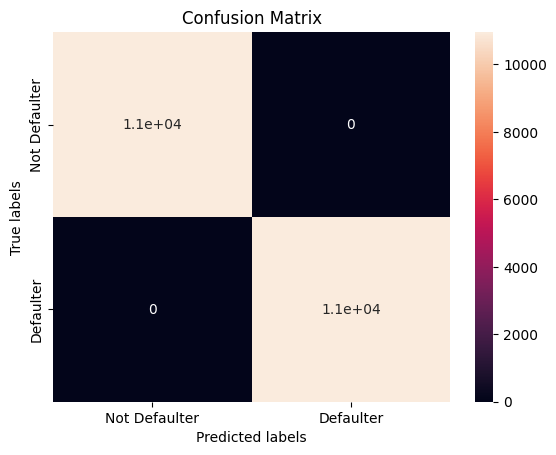

In [69]:
# Get the confusion matrix for both train and test

labels = ['Not Defaulter', 'Defaulter']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [71]:
y_preds_proba_lr = optimized_clf.predict_proba(X_test)[::,1]

In [72]:
'''
y_pred_proba = y_preds_proba_lr
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()'''

'\ny_pred_proba = y_preds_proba_lr\nfpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)\nauc = metrics.roc_auc_score(y_test, y_pred_proba)\nplt.plot(fpr,tpr,label="data 1, auc="+str(auc))\nplt.legend(loc=4)\nplt.show()'

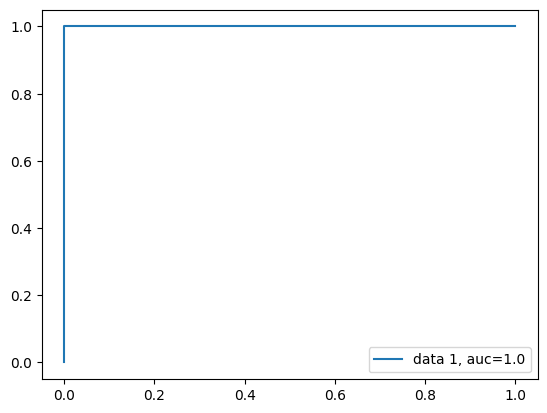

In [73]:
y_pred_proba = y_preds_proba_lr
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


# SVM

In [74]:
from sklearn.model_selection import GridSearchCV
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],   
              'kernel': ['rbf']} 
X = df_fr.drop(['IsDefaulter','Payement_Value','Dues'],axis=1)
y = df_fr['IsDefaulter']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
grid_clf = GridSearchCV(SVC(probability=True), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['rbf']},
             scoring='accuracy', verbose=3)

In [75]:
optimal_SVC_clf = grid_clf.best_estimator_
grid_clf.best_params_

{'C': 100, 'kernel': 'rbf'}

In [76]:
grid_clf.best_score_

0.9955738078941364

In [77]:
train_class_preds = optimal_SVC_clf.predict(X_train)
test_class_preds = optimal_SVC_clf.predict(X_test)
# Get the accuracy scores
train_accuracy_SVC = accuracy_score(train_class_preds,y_train)
test_accuracy_SVC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_lr)
print("The accuracy on test data is ", test_accuracy_lr)

The accuracy on train data is  1.0
The accuracy on test data is  1.0


In [78]:
test_accuracy_SVC = accuracy_score(test_class_preds,y_test)
test_precision_score_SVC = precision_score(test_class_preds,y_test)
test_recall_score_SVC = recall_score(test_class_preds,y_test)
test_f1_score_SVC = f1_score(test_class_preds,y_test)
test_roc_score_SVC = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_SVC)
print("The precision on test data is ", test_precision_score_SVC)
print("The recall on test data is ", test_recall_score_SVC)
print("The f1 on test data is ", test_f1_score_SVC)
print("The roc_score on test data is ", test_roc_score_SVC)

The accuracy on test data is  0.9972209356183418
The precision on test data is  0.9979618306466556
The recall on test data is  0.9964847363552266
The f1 on test data is  0.9972227365302722
The roc_score on test data is  0.997221960014348


[[10957     0]
 [    0 10958]]


[Text(0, 0.5, 'Not Defaulter'), Text(0, 1.5, 'Defaulter')]

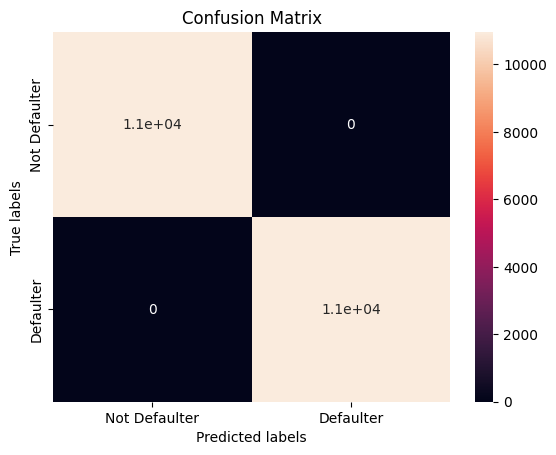

In [79]:
 # Get the confusion matrix for both train and test

labels = ['Not Defaulter', 'Defaulter']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

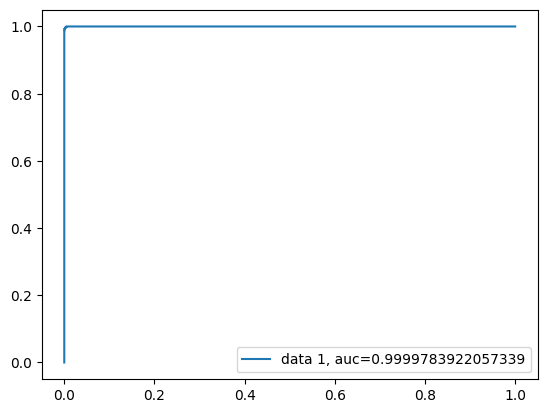

[CV 1/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END ...............C=0.001, penalty=l2;, score=1.000 total time=   0.1s
[CV 3/3] END ...............C=0.001, penalty=l2;, score=1.000 total time=   0.1s
[CV 2/3] END ................C=0.01, penalty=l2;, score=1.000 total time=   0.1s
[CV 1/3] END .................C=0.1, penalty=l2;, score=1.000 total time=   0.1s
[CV 2/3] END ...................C=1, penalty=l2;, score=1.000 total time=   0.1s
[CV 2/3] END ..................C=10, penalty=l2;, score=1.000 total time=   0.1s
[CV 1/3] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3] END ..................C=1000, penalty=l1;, score=nan total time=   0.0s
[CV 1/3] END ................C=1000, penalty=l2;, score=1.000 total time=   0.1s
[CV 1/3] END .................C=0.1, kernel=rbf;, score=0.986 total time=  33.3s
[CV 2/3] END ...............

In [80]:
# Get the predicted classes
train_class_preds = optimal_SVC_clf.predict(X_train)
test_class_preds = optimal_SVC_clf.predict(X_test)
y_pred_proba_SVC = optimal_SVC_clf.predict_proba(X_test)[::,1]
# ROC AUC CURVE
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_SVC)
auc = roc_auc_score(y_test, y_pred_proba_SVC)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# DECISION TREE

In [81]:
param_grid = {'max_depth': [20,30,50,100], 'min_samples_split':[0.1,0.2,0.4]}
from sklearn.tree import DecisionTreeClassifier  
X = df_fr.drop(['IsDefaulter','Payement_Value','Dues'],axis=1)
y = df_fr['IsDefaulter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
grid_DTC_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_DTC_clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50, 100],
                         'min_samples_split': [0.1, 0.2, 0.4]},
             scoring='accuracy', verbose=3)

In [82]:
grid_DTC_clf.best_score_

1.0

In [83]:
optimal_DTC_clf = grid_DTC_clf.best_estimator_
# Get the predicted classes
train_class_preds = optimal_DTC_clf.predict(X_train)
test_class_preds = optimal_DTC_clf.predict(X_test)
grid_DTC_clf.best_params_

{'max_depth': 20, 'min_samples_split': 0.1}

In [84]:
# Get the accuracy scores
train_accuracy_DTC = accuracy_score(train_class_preds,y_train)
test_accuracy_DTC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_DTC)
print("The accuracy on test data is ", test_accuracy_DTC)

The accuracy on train data is  1.0
The accuracy on test data is  1.0
[CV 1/3] END max_depth=20, min_samples_split=0.1;, score=1.000 total time=   0.1s
[CV 3/3] END max_depth=20, min_samples_split=0.2;, score=1.000 total time=   0.1s
[CV 1/3] END max_depth=30, min_samples_split=0.1;, score=1.000 total time=   0.1s
[CV 2/3] END max_depth=30, min_samples_split=0.2;, score=1.000 total time=   0.1s
[CV 3/3] END max_depth=30, min_samples_split=0.4;, score=1.000 total time=   0.1s
[CV 1/3] END max_depth=50, min_samples_split=0.2;, score=1.000 total time=   0.1s
[CV 2/3] END max_depth=50, min_samples_split=0.4;, score=1.000 total time=   0.1s
[CV 3/3] END max_depth=100, min_samples_split=0.1;, score=1.000 total time=   0.1s
[CV 1/3] END max_depth=100, min_samples_split=0.4;, score=1.000 total time=   0.1s
[CV 3/3] END max_depth=20, min_samples_split=0.1;, score=1.000 total time=   0.1s
[CV 1/3] END max_depth=20, min_samples_split=0.4;, score=1.000 total time=   0.1s
[CV 2/3] END max_depth=30, 

In [86]:
test_precision_score_DTC = precision_score(test_class_preds,y_test)
test_recall_score_DTC = recall_score(test_class_preds,y_test)
test_f1_score_DTC = f1_score(test_class_preds,y_test)
test_roc_score_DTC = roc_auc_score(test_class_preds,y_test)

print("\nThe precision on test data is ", test_precision_score_DTC)
print("The recall on test data is ", test_recall_score_DTC)
print("The F1-score on test data is ", test_f1_score_DTC)
print("The ROC-AUC score on test data is ", test_roc_score_DTC)


The precision on test data is  1.0
The recall on test data is  1.0
The F1-score on test data is  1.0
The ROC-AUC score on test data is  1.0


[[10957     0]
 [    0 10958]]


[Text(0, 0.5, 'Not Defaulter'), Text(0, 1.5, 'Defaulter')]

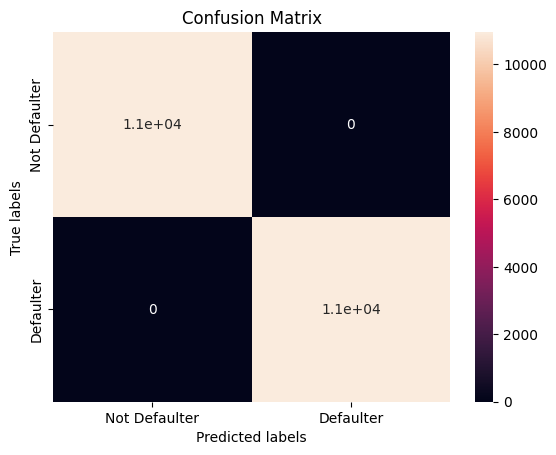

In [88]:
 # Get the confusion matrix for both train and test

labels = ['Not Defaulter', 'Defaulter']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

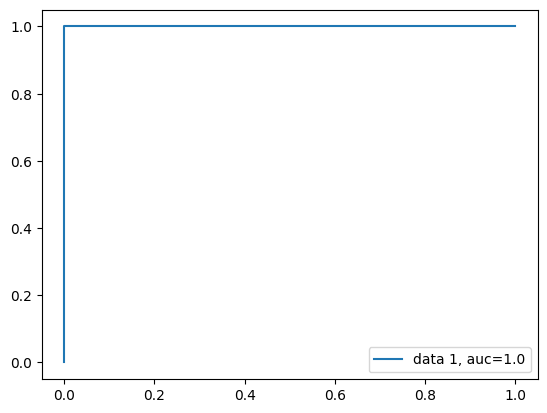

In [90]:
# Get the predicted classes
train_class_preds = optimal_DTC_clf.predict(X_train)
test_class_preds = optimal_DTC_clf.predict(X_test)
y_pred_proba_DTC = optimal_DTC_clf.predict_proba(X_test)[::,1]
# ROC AUC CURVE
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_DTC)
auc = roc_auc_score(y_test, y_pred_proba_DTC)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# RANDOM FOREST

In [91]:
from sklearn.ensemble import RandomForestClassifier
X = df_fr.drop(['IsDefaulter','Payement_Value','Dues'],axis=1)
y = df_fr['IsDefaulter']
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [92]:
# Get the predicted classes
train_class_preds = rf_clf.predict(X_train)
test_class_preds = rf_clf.predict(X_test)
# Get the accuracy scores
train_accuracy_rf = accuracy_score(train_class_preds,y_train)
test_accuracy_rf = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_rf)
print("The accuracy on test data is ", test_accuracy_rf)

The accuracy on train data is  1.0
The accuracy on test data is  1.0


In [93]:
test_accuracy_rf = accuracy_score(test_class_preds,y_test)
test_precision_score_rf = precision_score(test_class_preds,y_test)
test_recall_score_rf = recall_score(test_class_preds,y_test)
test_f1_score_rf = f1_score(test_class_preds,y_test)
test_roc_score_rf = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_rf)
print("The precision on test data is ", test_precision_score_rf)
print("The recall on test data is ", test_recall_score_rf)
print("The f1 on test data is ", test_f1_score_rf)
print("The roc_score on test data is ", test_roc_score_rf)

The accuracy on test data is  1.0
The precision on test data is  1.0
The recall on test data is  1.0
The f1 on test data is  1.0
The roc_score on test data is  1.0


In [94]:
param_grid = {'n_estimators': [100,150,200], 'max_depth': [10,20,30]}
grid_rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_rf_clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=3)

In [95]:
grid_rf_clf.best_score_

1.0

In [96]:
grid_rf_clf.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [97]:
optimal_rf_clf = grid_rf_clf.best_estimator_
# Get the predicted classes
train_class_preds = optimal_rf_clf.predict(X_train)
test_class_preds = optimal_rf_clf.predict(X_test)
# Get the accuracy scores
train_accuracy_rf = accuracy_score(train_class_preds,y_train)
test_accuracy_rf = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_rf)
print("The accuracy on test data is ", test_accuracy_rf)

The accuracy on train data is  1.0
The accuracy on test data is  0.9999073645206114


In [98]:
test_accuracy_rf = accuracy_score(test_class_preds,y_test)
test_precision_score_rf = precision_score(test_class_preds,y_test)
test_recall_score_rf = recall_score(test_class_preds,y_test)
test_f1_score_rf = f1_score(test_class_preds,y_test)
test_roc_score_rf = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_rf)
print("The precision on test data is ", test_precision_score_rf)
print("The recall on test data is ", test_recall_score_rf)
print("The f1 on test data is ", test_f1_score_rf)
print("The roc_score on test data is ", test_roc_score_rf)

The accuracy on test data is  0.9999073645206114
The precision on test data is  1.0
The recall on test data is  0.9998147462022972
The f1 on test data is  0.9999073645206115
The roc_score on test data is  0.9999073731011485


[[10957     0]
 [    0 10958]]


[Text(0, 0.5, 'Not Defaulter'), Text(0, 1.5, 'Defaulter')]

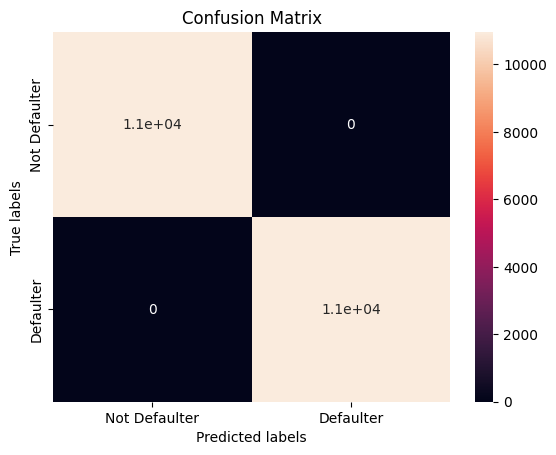

In [100]:
 # Get the confusion matrix for both train and test

labels = ['Not Defaulter', 'Defaulter']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

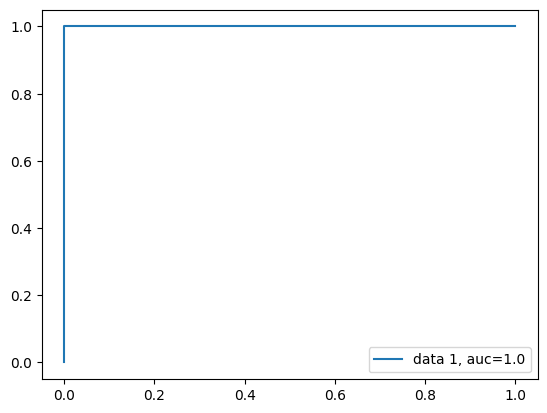

In [101]:
# Get the predicted classes
train_class_preds = optimal_rf_clf.predict(X_train)
test_class_preds = optimal_rf_clf.predict(X_test)
y_preds_proba_rf = optimal_rf_clf.predict_proba(X_test)[::,1]
import sklearn.metrics as metrics
y_pred_proba = y_preds_proba_rf
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# XGBoost

In [103]:
#import lightgbm and xgboost 
import lightgbm as lgb 
import xgboost as xgb
#The data is stored in a DMatrix object 
#label is used to define our outcome variable
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)
#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}
#training our model 
num_round=50
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

In [104]:
#Execution time of the model 
execution_time_xgb = stop-start 
execution_time_xgb

datetime.timedelta(microseconds=234946)

In [105]:
#now predicting our model on train set 
train_class_preds_probs=xg.predict(dtrain) 
#now predicting our model on test set 
test_class_preds_probs =xg.predict(dtest) 
len(train_class_preds_probs)

21915

In [106]:
train_class_preds = []
test_class_preds = []
for i in range(0,len(train_class_preds_probs)):
  if train_class_preds_probs[i] >= 0.5:
    train_class_preds.append(1)
  else:
    train_class_preds.append(0)

for i in range(0,len(test_class_preds_probs)):
  if test_class_preds_probs[i] >= 0.5:
    test_class_preds.append(1)
  else:
    test_class_preds.append(0)
test_class_preds_probs[:20]

array([0.04046348, 0.04046348, 0.9595401 , 0.04046348, 0.9595401 ,
       0.04046348, 0.9595401 , 0.9595401 , 0.04046348, 0.9595401 ,
       0.04046348, 0.04046348, 0.9595401 , 0.04046348, 0.04046348,
       0.9595401 , 0.04046348, 0.04046348, 0.04046348, 0.04046348],
      dtype=float32)

In [107]:
test_class_preds[:20]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

In [108]:
# Get the accuracy scores
train_accuracy_xgb = accuracy_score(train_class_preds,y_train)
test_accuracy_xgb = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_xgb)
print("The accuracy on test data is ", test_accuracy_xgb)

The accuracy on train data is  1.0
The accuracy on test data is  1.0


In [118]:
test_accuracy_xgb = accuracy_score(test_class_preds,y_test)
test_precision_xgb = precision_score(test_class_preds,y_test)
test_recall_score_xgb = recall_score(test_class_preds,y_test)
test_f1_score_xgb = f1_score(test_class_preds,y_test)
test_roc_score_xgb = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_xgb)
print("The precision on test data is ", test_precision_xgb)
print("The recall on test data is ", test_recall_score_xgb)
print("The f1 on test data is ", test_f1_score_xgb)
print("The roc_score on train data is ", test_roc_score_xgb)

The accuracy on test data is  1.0
The precision on test data is  1.0
The recall on test data is  1.0
The f1 on test data is  1.0
The roc_score on train data is  1.0


In [119]:
from xgboost import  XGBClassifier

In [120]:
X = df_fr.drop(['IsDefaulter','Payement_Value','Dues'],axis=1)
y = df_fr['IsDefaulter']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [122]:
gsearch1.best_score_

1.0

In [123]:
optimal_xgb = gsearch1.best_estimator_
# Get the predicted classes
train_class_preds = optimal_xgb.predict(X_train)
test_class_preds = optimal_xgb.predict(X_test)
# Get the accuracy scores
train_accuracy_xgb_tuned = accuracy_score(train_class_preds,y_train)
test_accuracy_xgb_tuned = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_xgb_tuned)
print("The accuracy on test data is ", test_accuracy_xgb_tuned)

The accuracy on train data is  1.0
The accuracy on test data is  1.0


In [124]:
test_accuracy_xgb_tuned = accuracy_score(test_class_preds,y_test)
test_precision_xgb_tuned = precision_score(test_class_preds,y_test)
test_recall_score_xgb_tuned = recall_score(test_class_preds,y_test)
test_f1_score_xgb_tuned = f1_score(test_class_preds,y_test)
test_roc_score_xgb_tuned = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_xgb_tuned)
print("The precision on test data is ", test_precision_xgb_tuned)
print("The recall on test data is ", test_recall_score_xgb_tuned)
print("The f1 on test data is ", test_f1_score_xgb_tuned)
print("The roc_score on train data is ", test_roc_score_xgb_tuned)

The accuracy on test data is  1.0
The precision on test data is  1.0
The recall on test data is  1.0
The f1 on test data is  1.0
The roc_score on train data is  1.0


In [125]:
pd.DataFrame(optimal_xgb.feature_importances_,
                                   index = columns,
                                    columns=['importance_xgb']).sort_values('importance_xgb',
                                                                        ascending=False)[:10]

,importance_xgb
default_payment_next_month,0.409472
PAY_SEPT_1,0.142358
PAY_AMT_SEPT,0.092044
PAY_JUL_1,0.070711
PAY_AUG_1,0.067735
PAY_SEPT_2,0.044811
PAY_AUG_2,0.042528
SEX,0.029013
PAY_JUN_1,0.026672
MARRIAGE_married,0.016214


[[10957     0]
 [    0 10958]]


[Text(0, 0.5, 'Not Defaulter'), Text(0, 1.5, 'Defaulter')]

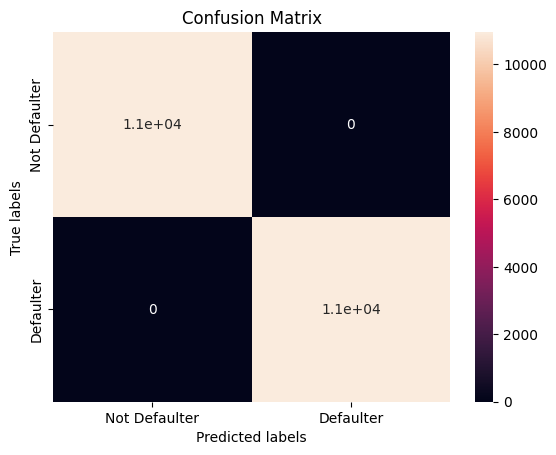

In [126]:
 # Get the confusion matrix for both train and test

labels = ['Not Defaulter', 'Defaulter']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

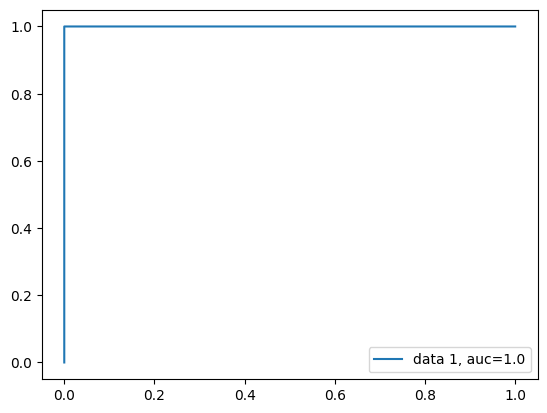

In [127]:
y_preds_proba_xgb = optimal_xgb.predict_proba(X_test)[::,1]
y_pred_proba = y_preds_proba_xgb
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# EVALUATION OF MODELS

In [128]:
recall_score

<function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [129]:
classifiers = ['Logistic Regression', 'SVC', 'Random Forest CLf', 'Xgboost Clf']
train_accuracy = [train_accuracy_lr, train_accuracy_SVC, train_accuracy_rf, train_accuracy_xgb_tuned]
test_accuracy = [test_accuracy_lr, test_accuracy_SVC, test_accuracy_rf, test_accuracy_xgb_tuned]
precision_score = [test_precision_score_lr, test_precision_score_SVC, test_precision_score_rf, test_precision_xgb_tuned]
recall_score = [test_recall_score_lr, test_recall_score_SVC, test_recall_score_rf, test_recall_score_xgb_tuned]
f1_score = [test_f1_score_lr, test_f1_score_SVC, test_f1_score_rf, test_f1_score_xgb_tuned]
pd.DataFrame({'Classifier':classifiers, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'Precision Score': precision_score, 'Recall Score': recall_score, 'F1 Score': f1_score })

,Classifier,Train Accuracy,Test Accuracy,Precision Score,Recall Score,F1 Score
0,Logistic Regression,1.0,1.000000,1.000000,1.000000,1.000000
1,SVC,1.0,0.997221,0.997962,0.996485,0.997223
2,Random Forest CLf,1.0,0.999907,1.000000,0.999815,0.999907
3,Xgboost Clf,1.0,1.000000,1.000000,1.000000,1.000000


# PLOTTING ROC AUC OF ALL MODELS

In [131]:
# Initialize an empty list to store results
result_list = []

# Iterate over classifiers and their probabilities
for pair in classifiers_proba:
    # Calculate the FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_test, pair[1])
    auc = roc_auc_score(y_test, pair[1])
    
    # Append the results to the list as a dictionary
    result_list.append({
        'classifiers': pair[0].__class__.__name__,
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc
    })

# Convert the list of dictionaries into a DataFrame
result_table = pd.DataFrame(result_list)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table


,fpr,tpr,auc
classifiers,,,
LogisticRegression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00018528812303131369, 0.17417083564943...",1.0
RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.009079118028534372, 0.0101908467667222...",1.0
XGBClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0007411524921252547, 0.001111728738187...",1.0
SVC,"[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]",1.0


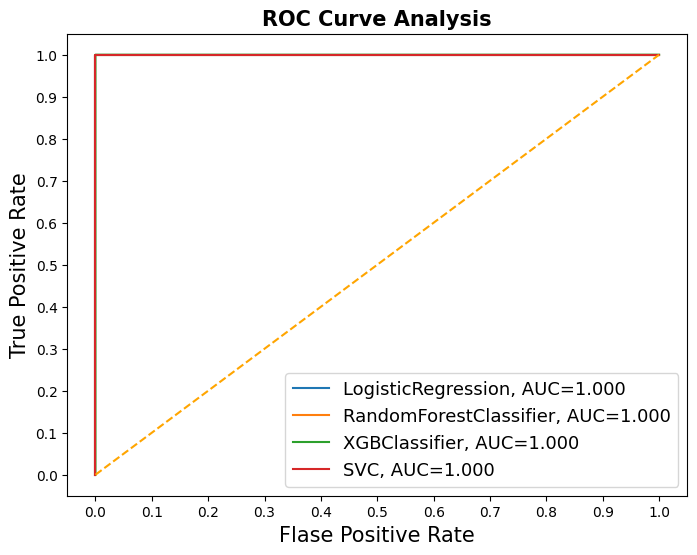

In [132]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

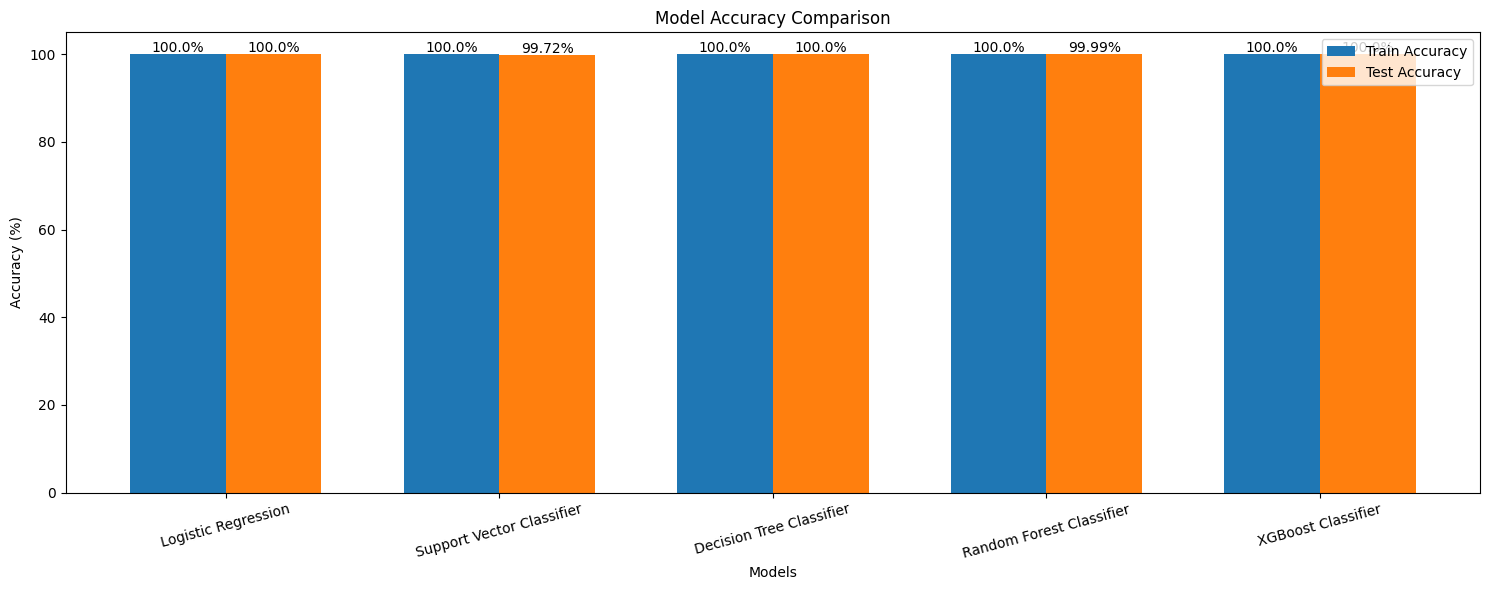

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their corresponding accuracies
models = ['Logistic Regression', 'Support Vector Classifier', 
          'Decision Tree Classifier', 'Random Forest Classifier', 
          'XGBoost Classifier']

# Retrieve the accuracy values from your previous computations
train_accuracies = [train_accuracy_lr, train_accuracy_SVC, 
                    train_accuracy_DTC, train_accuracy_rf, 
                    train_accuracy_xgb]

test_accuracies = [test_accuracy_lr, test_accuracy_SVC, 
                   test_accuracy_DTC, test_accuracy_rf, 
                   test_accuracy_xgb]

# Convert accuracies to percentages
train_accuracies_percent = [round(acc * 100, 2) for acc in train_accuracies]
test_accuracies_percent = [round(acc * 100, 2) for acc in test_accuracies]

# Plotting
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))
bars1 = ax.bar(x - width/2, train_accuracies_percent, width, label='Train Accuracy')
bars2 = ax.bar(x + width/2, test_accuracies_percent, width, label='Test Accuracy')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}%', ha='center')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}%', ha='center')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
